Prepared 1483 sentence-level samples.
Feature shape: (1483, 1536), targets shape: (1483,)
Device: cpu
Epoch 1/20 - train_loss=0.1169  val_loss=0.3219  val_MAE=0.5569
[Saved best] val_loss=0.321907 -> output_regression/best_regressor.pt
Epoch 2/20 - train_loss=0.0282  val_loss=0.2827  val_MAE=0.5215
[Saved best] val_loss=0.282719 -> output_regression/best_regressor.pt
Epoch 3/20 - train_loss=0.0145  val_loss=0.1295  val_MAE=0.3470
[Saved best] val_loss=0.129544 -> output_regression/best_regressor.pt
Epoch 4/20 - train_loss=0.0115  val_loss=0.0298  val_MAE=0.1488
[Saved best] val_loss=0.029836 -> output_regression/best_regressor.pt
Epoch 5/20 - train_loss=0.0097  val_loss=0.0120  val_MAE=0.0844
[Saved best] val_loss=0.011974 -> output_regression/best_regressor.pt
Epoch 6/20 - train_loss=0.0090  val_loss=0.0113  val_MAE=0.0819
[Saved best] val_loss=0.011350 -> output_regression/best_regressor.pt
Epoch 7/20 - train_loss=0.0091  val_loss=0.0117  val_MAE=0.0866
Epoch 8/20 - train_loss=0.0081

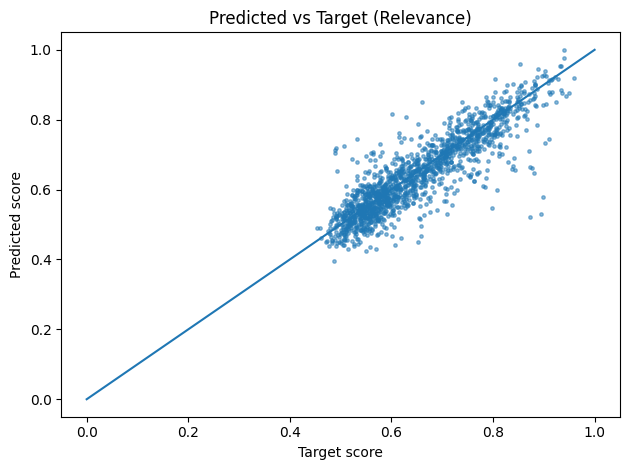

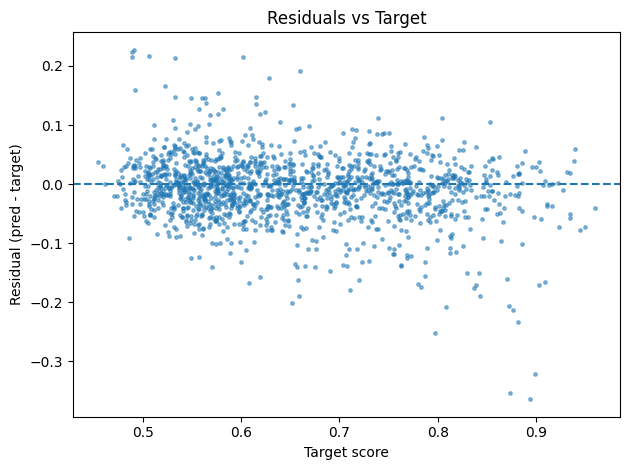

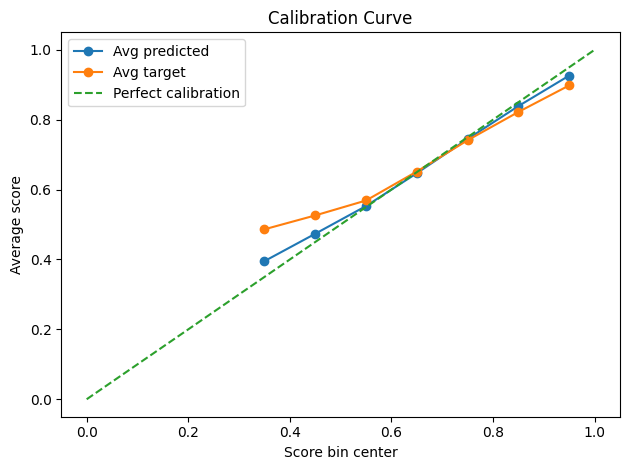

In [2]:
import os, json, math, random
from pathlib import Path

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Optional: sentence segmentation (NLTK)
try:
    import nltk
    from nltk.tokenize import sent_tokenize
    try:
        nltk.data.find("tokenizers/punkt")
    except LookupError:
        nltk.download("punkt")
    try:
        nltk.data.find("tokenizers/punkt_tab")
    except LookupError:
        nltk.download("punkt_tab")
except Exception as e:
    raise SystemExit("Please install nltk: pip install nltk") from e

# Sentence embeddings
try:
    from sentence_transformers import SentenceTransformer
except Exception as e:
    raise SystemExit("Please install sentence-transformers: pip install sentence-transformers") from e

# ------------------
# User-set paths
# ------------------
DATA_PATH = Path("/Users/ad1/KCL/Dissertation/Dataset/reformatted_gpt_o1_responses_with_labels.json")  # <- change if needed
OUT_DIR = Path("./output_regression")  # where to save model and CSV
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ------------------
# Load dataset (expects a LIST of items, each with question_answer_pairs and ground_truth)
# ------------------
data = json.loads(Path(DATA_PATH).read_text(encoding="utf-8"))
if not isinstance(data, list):
    raise ValueError("Expected dataset JSON to be a LIST of items.")

# ------------------
# Build samples: (question, sentence, target_score)
# target_score is an automatic pseudo-label: cosine(sentence, ground_truth) mapped to [0,1].
# If an item lacks ground_truth, we skip it.
# ------------------
model_name = "sentence-transformers/all-MiniLM-L6-v2"
encoder = SentenceTransformer(model_name)

def cosine(a: np.ndarray, b: np.ndarray) -> float:
    denom = float(np.linalg.norm(a) * np.linalg.norm(b))
    return 0.0 if denom == 0.0 else float(np.dot(a, b) / denom)

samples = []  # list of (question, sentence, target)
for item in data:
    gt = (item.get("ground_truth") or "").strip()
    if not gt:
        continue
    # Encode ground-truth ONCE per item, with normalization for stable cosine
    gt_vec = encoder.encode([gt], convert_to_numpy=True, normalize_embeddings=True)[0]
    pairs = item.get("question_answer_pairs", [])
    for qa in pairs:
        q = (qa.get("question") or "").strip()
        ans = (qa.get("answer") or "").strip()
        if not ans:
            continue
        # Segment answer into sentences
        sents = [s.strip() for s in sent_tokenize(ans) if s.strip()]
        for s in sents:
            # pseudo target via cosine with ground truth ([-1,1] -> [0,1])
            s_vec  = encoder.encode([s], convert_to_numpy=True, normalize_embeddings=True)[0]
            sim = cosine(gt_vec, s_vec)
            target = (sim + 1.0) / 2.0
            samples.append((q, s, float(target)))

if not samples:
    raise ValueError("No samples built. Check that your dataset has ground_truth and answers.")

print(f"Prepared {len(samples)} sentence-level samples.")

# ------------------
# Build feature matrix
# Feature = concat([q_emb, s_emb, |q_emb - s_emb|, q_emb * s_emb])
# ------------------
questions = [q for (q, s, y) in samples]
sentences = [s for (q, s, y) in samples]
targets   = np.array([y for (q, s, y) in samples], dtype=np.float32)

# Encode in batches for speed
def batched_encode(texts, batch_size=64):
    out = []
    for i in range(0, len(texts), batch_size):
        out.append(
            encoder.encode(
                texts[i:i+batch_size],
                convert_to_numpy=True,
                normalize_embeddings=True
            )
        )
    return np.vstack(out)

q_embs = batched_encode(questions, batch_size=64)
s_embs = batched_encode(sentences, batch_size=64)

features = np.concatenate(
    [q_embs, s_embs, np.abs(q_embs - s_embs), q_embs * s_embs],
    axis=1
).astype(np.float32)
print(f"Feature shape: {features.shape}, targets shape: {targets.shape}")

# ------------------
# Train/Val/Test split
# ------------------
rng = np.random.default_rng(42)
idx = np.arange(len(features))
rng.shuffle(idx)

val_frac  = 0.10
test_frac = 0.10
n_val  = max(1, int(len(idx) * val_frac))
n_test = max(1, int(len(idx) * test_frac))
val_idx  = idx[:n_val]
test_idx = idx[n_val:n_val+n_test]
train_idx = idx[n_val+n_test:]

X_train = torch.from_numpy(features[train_idx])
y_train = torch.from_numpy(targets[train_idx])
X_val   = torch.from_numpy(features[val_idx])
y_val   = torch.from_numpy(targets[val_idx])
X_test  = torch.from_numpy(features[test_idx])
y_test  = torch.from_numpy(targets[test_idx])

train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val, y_val)
test_ds  = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ------------------
# Simple MLP regressor
# ------------------
input_dim = features.shape[1]
model = nn.Sequential(
    nn.Linear(input_dim, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
).to(device)

# Slight weight decay to reduce overfitting and encourage spread
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1)

best_val = float("inf")
patience, bad = 3, 0
BEST_PATH = OUT_DIR / "best_regressor.pt"

# ------------------
# Training loop
# ------------------
epochs = 20
for epoch in range(1, epochs + 1):
    model.train()
    run_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb).squeeze(-1)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
    train_loss = run_loss / max(1, len(train_loader))

    # Val
    model.eval()
    v_loss, v_mae = 0.0, 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).squeeze(-1)
            v_loss += criterion(preds, yb).item()
            v_mae += torch.mean(torch.abs(preds - yb)).item()
    v_loss /= max(1, len(val_loader))
    v_mae  /= max(1, len(val_loader))
    print(f"Epoch {epoch}/{epochs} - train_loss={train_loss:.4f}  val_loss={v_loss:.4f}  val_MAE={v_mae:.4f}")

    # Step LR scheduler and handle early stopping
    scheduler.step(v_loss)
    if v_loss < best_val - 1e-6:
        best_val, bad = v_loss, 0
        torch.save(model.state_dict(), str(BEST_PATH))
        print(f"[Saved best] val_loss={v_loss:.6f} -> {BEST_PATH}")
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping triggered.")
            break

# ------------------
# Save model and per-sentence predictions
# ------------------
MODEL_PATH = OUT_DIR / "relevance_regressor_simple.pt"
torch.save(model.state_dict(), str(MODEL_PATH))
print("Saved model to", MODEL_PATH)

# Make predictions for all samples and save a CSV
model.eval()
with torch.no_grad():
    all_preds = model(torch.from_numpy(features).to(device)).squeeze(-1).cpu().numpy().astype(float)
# keep a clipped copy for metrics/plots against [0,1] targets
all_preds = np.clip(all_preds, 0.0, 1.0)

import csv

# Save top-50 absolute errors for qualitative review
ERR_CSV_PATH = OUT_DIR / "top_errors.csv"
abs_err = np.abs(all_preds - targets)
order = np.argsort(-abs_err)  # descending
with open(ERR_CSV_PATH, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["rank","question","sentence","target","pred","abs_err"])
    for rank, i in enumerate(order[:50], start=1):
        q, s, t = samples[i]
        w.writerow([rank, q, s, f"{t:.6f}", f"{all_preds[i]:.6f}", f"{abs_err[i]:.6f}"])
print("Saved top errors to", ERR_CSV_PATH)

CSV_PATH = OUT_DIR / "sentence_relevance_predictions.csv"
with open(CSV_PATH, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["index","question","sentence","target_score","predicted_score"])
    for i,(q,s,t) in enumerate(samples):
        w.writerow([i, q, s, f"{t:.6f}", f"{all_preds[i]:.6f}"])

print("Saved predictions to", CSV_PATH)

# Optional: peek a few rows
for i in range(3):
    print(f"[{i}] target={samples[i][2]:.3f}  pred={all_preds[i]:.3f}  sent={samples[i][1][:80]}")

# ------------------
# Evaluate with Mean Squared Error (MSE)
# ------------------
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(targets, all_preds)
print(f"\nFinal Mean Squared Error (MSE): {mse:.6f}")

# === Extra regression metrics ===
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
import numpy as np
import matplotlib.pyplot as plt

mse = mean_squared_error(targets, all_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(targets, all_preds)
r2  = r2_score(targets, all_preds)
pearson_r, pearson_p = pearsonr(targets, all_preds)
spearman_r, spearman_p = spearmanr(targets, all_preds)

print(f"MSE   : {mse:.6f}")
print(f"RMSE  : {rmse:.6f}")
print(f"MAE   : {mae:.6f}")
print(f"R^2   : {r2:.4f}")
print(f"Pearson r  : {pearson_r:.4f} (p={pearson_p:.2e})")
print(f"Spearman r : {spearman_r:.4f} (p={spearman_p:.2e})")

# === Binary F1 via validation-tuned threshold (tune on val, evaluate on test) ===
from sklearn.metrics import f1_score, precision_score, recall_score

# Validation predictions (for threshold tuning)
model.eval()
with torch.no_grad():
    val_preds = model(X_val.to(device)).squeeze(-1).cpu().numpy().astype(float)
val_preds = np.clip(val_preds, 0.0, 1.0)
val_targets_np = y_val.numpy().astype(float)

# Test predictions (for final reporting)
with torch.no_grad():
    test_preds = model(X_test.to(device)).squeeze(-1).cpu().numpy().astype(float)
test_preds = np.clip(test_preds, 0.0, 1.0)
test_targets_np = y_test.numpy().astype(float)

# Choose a threshold on VAL that maximizes F1, but only among thresholds that produce both classes
best_thr, best_f1 = 0.60, -1.0
candidates = np.linspace(0.40, 0.80, 81)
for t in candidates:
    y_true_val = (val_targets_np >= t).astype(int)
    y_pred_val = (val_preds >= t).astype(int)
    # skip degenerate thresholds where either side has only one class
    if y_true_val.mean() in (0.0, 1.0) or y_pred_val.mean() in (0.0, 1.0):
        continue
    f1 = f1_score(y_true_val, y_pred_val, zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr = f1, float(t)

# If no non-degenerate threshold found, fall back to a sensible fixed threshold
if best_f1 < 0:
    best_thr = 0.60

# Report F1/precision/recall on the TEST split using the selected threshold
y_true_test = (test_targets_np >= best_thr).astype(int)
y_pred_test = (test_preds >= best_thr).astype(int)
prec = precision_score(y_true_test, y_pred_test, zero_division=0)
rec  = recall_score(y_true_test, y_pred_test, zero_division=0)
f1   = f1_score(y_true_test, y_pred_test, zero_division=0)

print(f"\n[Classification view] Threshold (val-tuned) = {best_thr:.3f}")
print(f"Precision (test) = {prec:.4f}  Recall (test) = {rec:.4f}  F1 (test) = {f1:.4f}")

# === Scatter: predicted vs target ===
plt.figure()
plt.scatter(targets, all_preds, s=6, alpha=0.5)
plt.plot([0,1], [0,1])  # ideal line
plt.xlabel("Target score")
plt.ylabel("Predicted score")
plt.title("Predicted vs Target (Relevance)")
plt.tight_layout()
plt.savefig(OUT_DIR / "pred_vs_target.png", dpi=300)
plt.show()

# === Residuals plot ===
residuals = all_preds - targets
plt.figure()
plt.scatter(targets, residuals, s=6, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Target score"); plt.ylabel("Residual (pred - target)")
plt.title("Residuals vs Target")
plt.tight_layout()
plt.savefig(OUT_DIR / "residuals.png", dpi=300)
plt.show()

# === Calibration curve (binned) ===
bins = np.linspace(0, 1, 11)
idx  = np.digitize(all_preds, bins) - 1
bin_centers, avg_target, avg_pred = [], [], []
for b in range(len(bins)-1):
    mask = (idx == b)
    if mask.any():
        bin_centers.append((bins[b] + bins[b+1]) / 2)
        avg_target.append(float(np.mean(targets[mask])))
        avg_pred.append(float(np.mean(all_preds[mask])))

plt.figure()
plt.plot(bin_centers, avg_pred, marker='o', label="Avg predicted")
plt.plot(bin_centers, avg_target, marker='o', label="Avg target")
plt.plot([0,1], [0,1], linestyle='--', label="Perfect calibration")
plt.xlabel("Score bin center")
plt.ylabel("Average score")
plt.title("Calibration Curve")
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / "calibration.png", dpi=300)
plt.show()